In [102]:
# TODO: REFACTOR EVERYTHING TO WHERE THEY BELONG DAMN IT

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [5]:
with open('config/EDA.json') as fh:
    configs = json.load(fh)
    EDA_VIZ_PATH, RESP_PATH = configs['EDA_VIZ_PATH'], configs['RESP_PATH']

In [7]:
resp = pd.read_csv(RESP_PATH)
resp.head()

,location_name,FIPS,cause_name,sex,year_id,mx,lower,upper
0,Arizona,4.0,Chronic respiratory diseases,Male,1980,85.537453,82.512092,88.730352
1,Arizona,4.0,Chronic respiratory diseases,Male,1981,83.543162,80.767829,86.672654
2,Arizona,4.0,Chronic respiratory diseases,Male,1982,80.069996,77.206266,82.906518
3,Arizona,4.0,Chronic respiratory diseases,Male,1983,77.759188,75.248279,80.334953
4,Arizona,4.0,Chronic respiratory diseases,Male,1984,81.778981,79.068637,84.315335


In [8]:
resp.shape

(3353700, 8)

Dataset makeup:

| FIPS | CAUSE | sex | year |
| --- | --- | --- | --- |
| FIPS_1 | D1 | Male | 1980 |
| FIPS_1 | D1 | Male | ... |
| FIPS_1 | D1 | Male | 2014 |
| FIPS_1 | D1 | Female | 1980 |
| FIPS_1 | D1 | Female | ... |
| FIPS_1 | D1 | Female | 2014 |
| FIPS_1 | D1 | Both | 1980 |
| FIPS_1 | D1 | Both | ... |
| FIPS_1 | D1 | Both | 2014 |

35 years * 3 genders = 105 entry per county, 3193 * 105 = 335265 per disease for all counties, 335265 * 10 = 3352650  
rows + (105 * 10) rows with null FIPS (US estimation)

sub na FIPS with -1 since it refers US as whole

In [9]:
resp['FIPS'] = resp['FIPS'].fillna(-1)

duplicate names in FIPS. So many named after presidents

# Mortality - mean
default: compare against genders. (not looking at gender = BOTH)

### mx vs year  
The age-standardized mortality rate is comparable (because it is standarized)  
**Standarization rationale:**
>The numbers of deaths per 100 000 population are influenced by the age distribution of the population. Two populations with the same age-specific mortality rates for a particular cause of death will have different overall death rates if the age distributions of their populations are different. Age-standardized mortality rates adjust for differences in the age distribution of the population by applying the observed age-specific mortality rates for each population to a standard population.

In [128]:
def plot_mx_by_year(resp, compare=True, ax = None):
    if compare:
        resp = resp[['year_id','sex', 'mx']].loc[resp['sex'].isin({'Male', 'Female'})]
    else:
        resp = resp[['year_id','sex', 'mx']].loc[resp['sex'].isin({'Both'})]
    year_mx = resp.groupby(['year_id', 'sex']).mean().reset_index()
#     display(year_mx.head())
    if ax is not None:
        return sns.lineplot(x='year_id', y='mx', hue='sex', data=year_mx, ax=ax)
    return sns.lineplot(x='year_id', y='mx', hue='sex', data=year_mx)

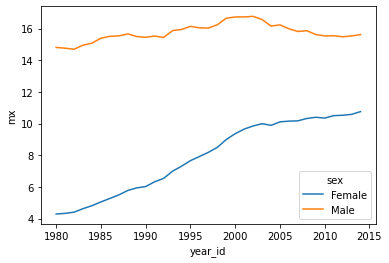

In [129]:
year_mx = plot_mx_by_year(resp)

### Granualarization 1: going into every disease

In [130]:
def plot_mx_year_by_cause(resp, causes, compare = True):
    nrows, ncols = 3, 4
    if len(causes) > 10:
        return -1
    if compare:
        resp = resp.loc[resp['sex'].isin({'Male', 'Female'})]
    else:
        resp = resp.loc[resp['sex'].isin({'Both'})]
    if not isinstance(list(causes),list):
        print('argument not a list')
        causes = [causes]
    cause_groups = resp.groupby('cause_name')
#     print(causes)
    fig = plt.figure(figsize = (16,9))
    
    for i, cause in enumerate(causes):
#         print(i,cause)
        ax = plt.subplot(nrows, ncols, i+1)
        ax.set_title(f"MR of {cause}")
        subgroup = cause_groups.get_group(cause)
        plot_mx_by_year(cause_groups.get_group(cause), compare, ax = ax)
    plt.tight_layout()
    fig.savefig(f"{EDA_VIZ_PATH}/MR_of_diseases_over_year_gender_compare_{compare}.png")
    return fig

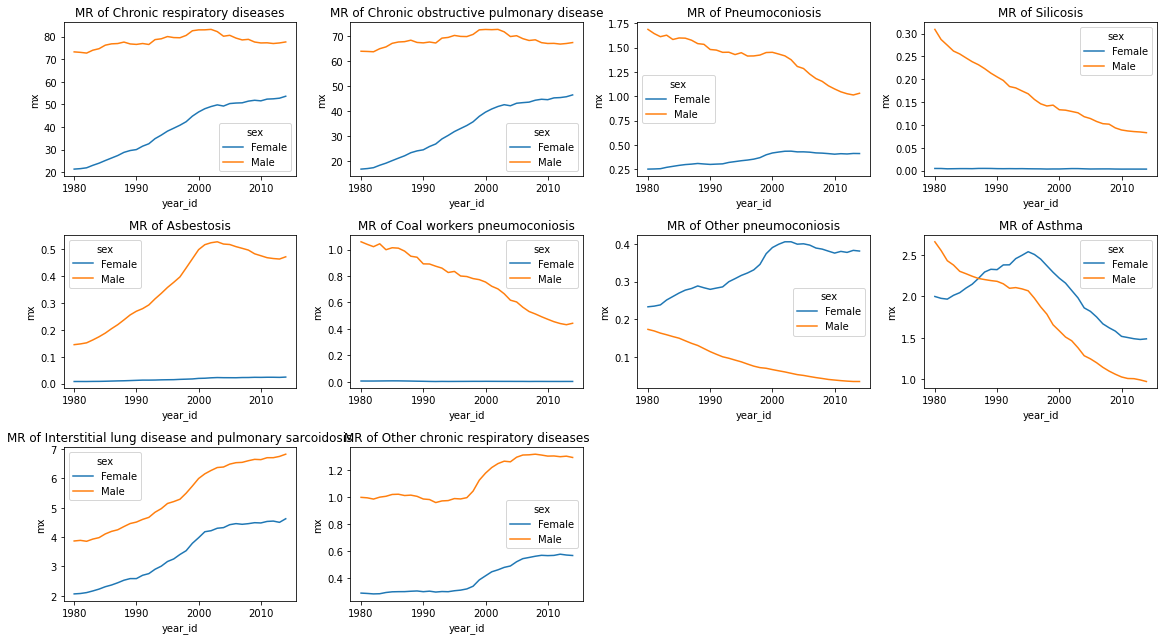

In [131]:
fig = plot_mx_year_by_cause(resp, list(resp.cause_name.unique()))

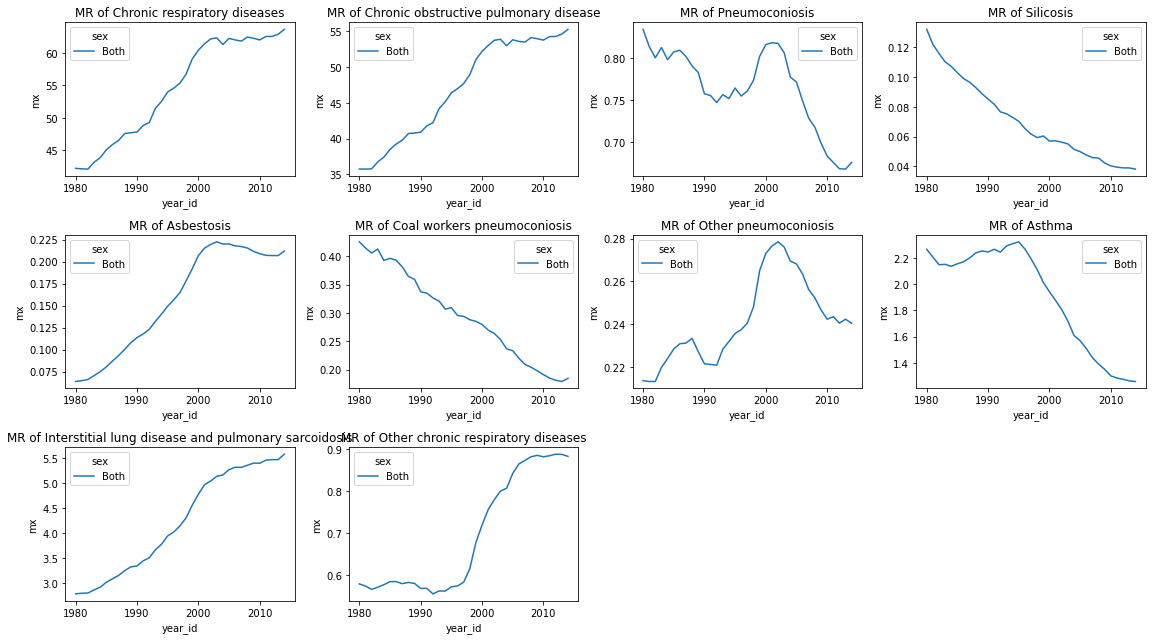

In [132]:
fig = plot_mx_year_by_cause(resp, list(resp.cause_name.unique()), compare=False)

# Mortality - variance 
# TODO